# Eigenfashion
## Nicolas A Gort Freitas
### CS156 Machine Learning

In [373]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings

from glob import glob
from PIL import Image
from scipy.misc import imread,imresize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.pipeline import Pipeline

warnings.filterwarnings(action='once')

### Function bank

In [542]:
def flat_to_rgb(flt,size):
    flatrgb = flt.reshape(size[0]*size[1],3)
    prergb = np.array([tuple([int(j) for j in i]) for i in flatrgb])
    rgb = prergb.reshape(size[1],size[0],3)/255
    
    return rgb

def img_to_array(filename,size):
    img = Image.open(filename)
    img = img.resize(size)
    return np.array(img).reshape(1,-1)

### Paths

In [227]:
man_paths = glob("Man's Clothing - n03746330/*")
wo_paths = glob("Woman's Clothing - n04596852/*")

### Data preparation / Train-test split

In [248]:
data = [
    (img_to_array(path,(200,250)),1)
        for path in man_paths] + [
    (img_to_array(path,(200,250)),0)
        for path in wo_paths]

In [252]:
np.random.shuffle(data)

X = np.array([feat for (feat,lab) in data]).reshape(-1,250*200*3)
y = np.array([lab for (feat,lab) in data]).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2512, 150000), (2512, 1), (2009, 150000), (2009, 1), (503, 150000), (503, 1))

## Part 1: Logistic Regression on Image data

In [259]:
lr = LogisticRegression()
lr.fit(X_train,y_train)


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Classifier performance metrics

In [286]:
y_probs_train = lr.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_probs_train)
precision_train, recall_train, _tr = precision_recall_curve(y_train, y_probs_train)
lr_f1_train = f1_score(y_train,lr.predict(X_train))

y_probs_test = lr.predict_proba(X_test)[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_probs)
lr_f1_test = f1_score(y_test,lr.predict(X_test))


### Classifier performance analysis

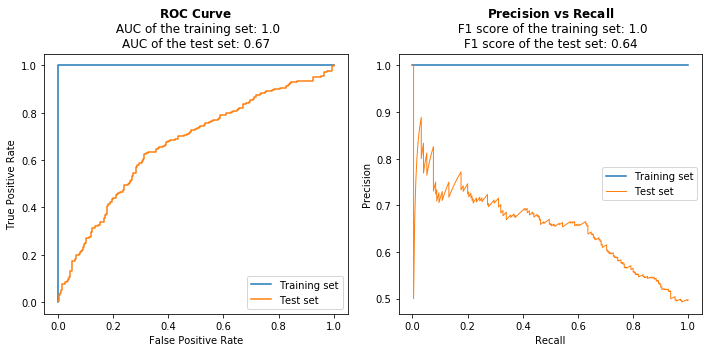

In [390]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].plot(fpr_train,tpr_train,label='Training set')
axes[0].plot(fpr_test,tpr_test,label='Test set')


axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title( r'$\bf{ROC\ Curve}$' + '\n AUC of the training set: {}\nAUC of the test set: {}'.format(round(auc(fpr_train,tpr_train),2),round(auc(fpr_test,tpr_test),2)))
axes[0].legend()

axes[1].plot(recall_train,precision_train,label='Training set')
axes[1].plot(recall_test,precision_test,label='Test set',linewidth=1)

axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')
axes[1].set_title( r'$\bf{Precision\ vs\ Recall}$' + '\n F1 score of the training set: {}\nF1 score of the test set: {}'.format(round(lr_f1_train,2),round(lr_f1_test,2)))
axes[1].legend()

plt.subplots_adjust(wspace=0.5,hspace=.25)
plt.tight_layout()

plt.show()

## Part 2: Principal Component Analysis
### How many components are enough?

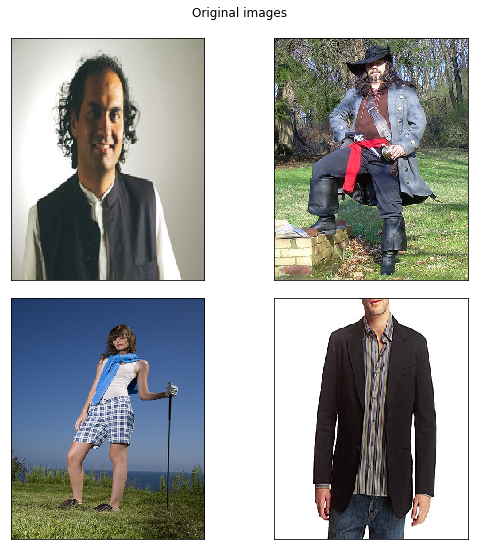

In [362]:
fig, axes = plt.subplots(2,2, figsize = (8,8))
fig.suptitle('Original images')
        
for n,a in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axes[a].imshow(flat_to_rgb(X_train[n],(200,250)))
    axes[a].get_xaxis().set_visible(False)
    axes[a].get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

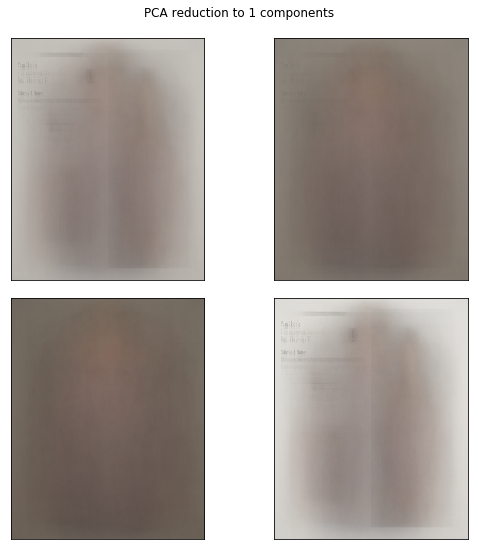

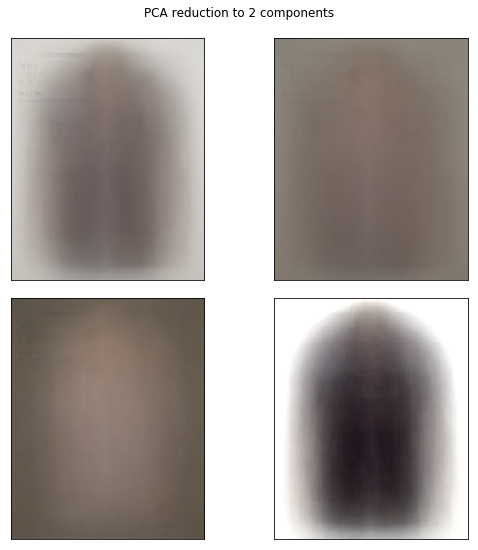

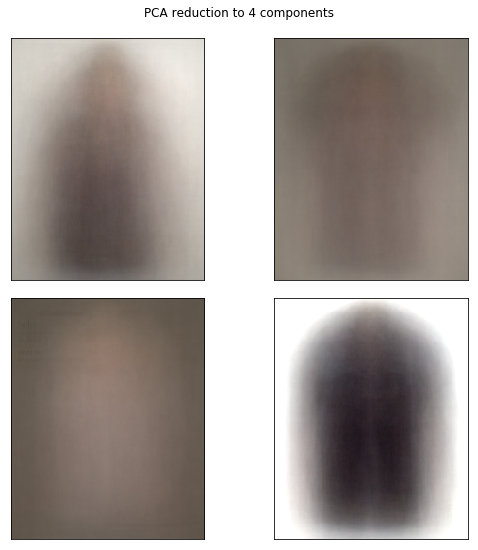

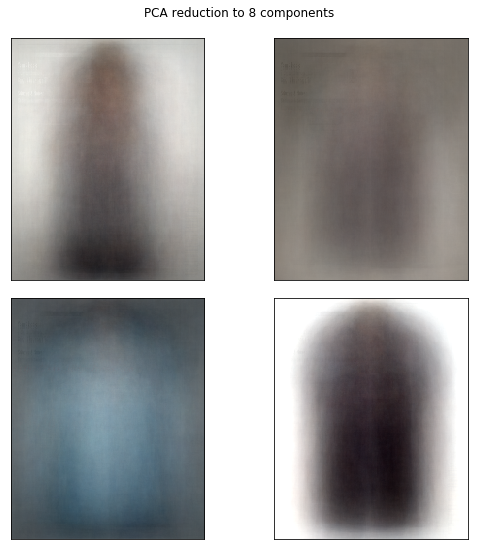

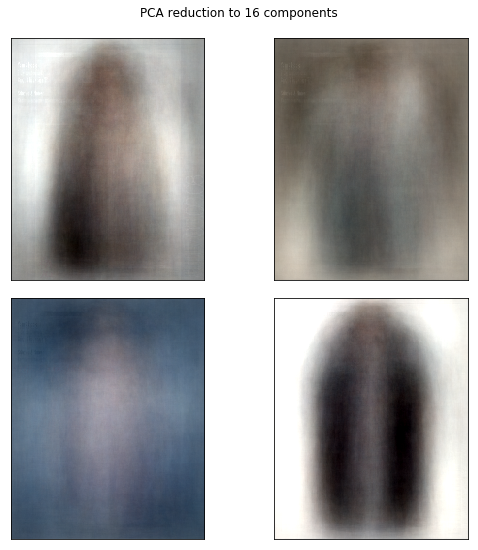

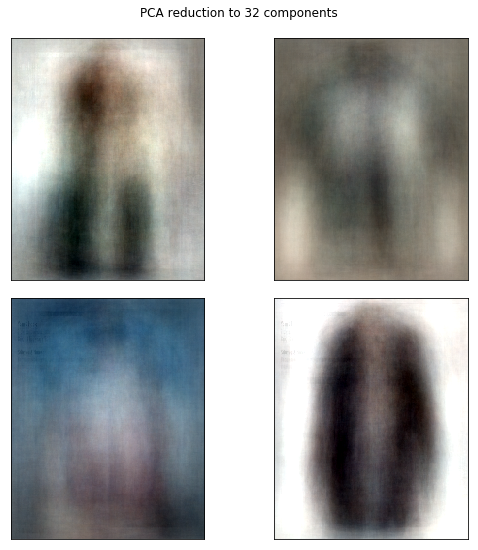

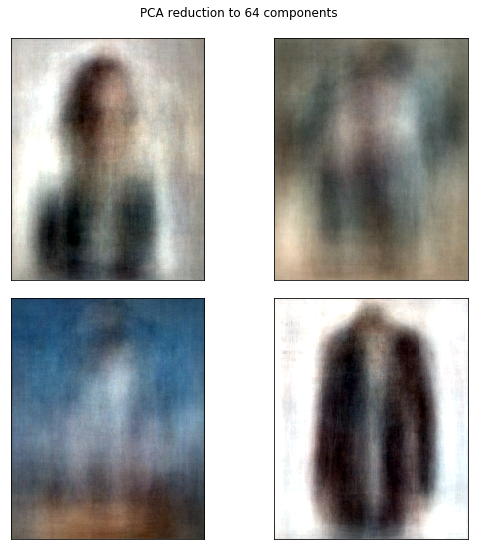

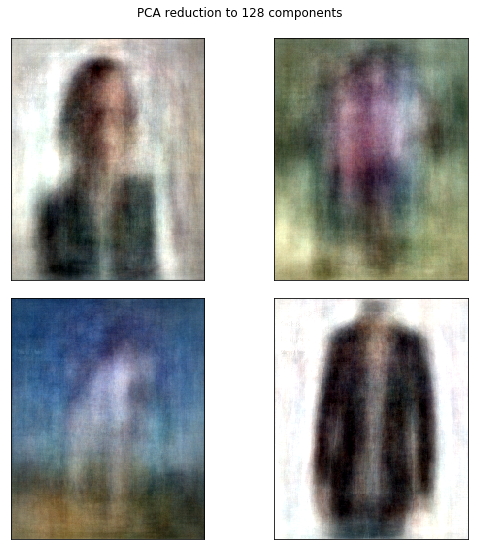

In [358]:
for c in [1,2,4,8,16,32,64,128]:
        pca = PCA(n_components = c)
        pca.fit(X)
        
        fig, axes = plt.subplots(2,2, figsize = (8,8))
        fig.suptitle('PCA reduction to {} components'.format(c))
        
        for n,a in enumerate([(0,0),(0,1),(1,0),(1,1)]):
            
            post_pca = pca.transform([X_train[n]])
            pca_inv = pca.inverse_transform(post_pca)
            
            
            axes[a].imshow(flat_to_rgb(pca_inv[0],(200,250)))
            axes[a].get_xaxis().set_visible(False)
            axes[a].get_yaxis().set_visible(False)


        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        

There seems to be no significant gain of visual resolution  
after 64 components, so my educated guess would be that 64  
is the optimal number of components for a PCA+LR analysis.  
I will attempt to contrast this with the results of a  
grid search to find the optimal number of components for  
my classification pipeline.

### Finding optimal hyperparameters for dimensionality reduction and classification 
### Grid search with cross-validation
 http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

In [381]:
pipe_pca = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LogisticRegression())
])

N_COMPONENTS = range(4,64,10)
C_OPTIONS = [1, 10, 20, 50]

param_grid_pca = {
        'reduce_dim__n_components': N_COMPONENTS,
        'classify__C': C_OPTIONS
    }
grid_pca = GridSearchCV(pipe_pca, cv=3, n_jobs=1, param_grid=param_grid_pca)

grid_pca.fit(X_train, y_train.reshape(len(y_train)))

print('Best number of components: {}'.format(grid_pca.best_estimator_.named_steps['reduce_dim'].n_components))
print('Best C for Logistic Regression: {}'.format(grid_pca.best_estimator_.named_steps['classify'].C))

Best number of components: 54
Best C for Logistic Regression: 1


### PCA(54) + Logistic regression

In [376]:
# using 54 components as suggested
# by grid search

pca_clf = PCA(n_components=54)

pca_clf.fit(X_train)
X_pca_train = pca_clf.transform(X_train)
X_pca_test = pca_clf.transform(X_test)

lr_pca = LogisticRegression()

lr_pca.fit(X_pca_train,y_train)



y_pca_probs_train = lr_pca.predict_proba(X_pca_train)[:,1]
fpr_pca_train, tpr_pca_train, thresholds_pca_train = roc_curve(y_train, y_pca_probs_train)
precision_pca_train, recall_pca_train, _pca_tr = precision_recall_curve(y_train, y_pca_probs_train)
lr_f1_pca_train = f1_score(y_train,lr_pca.predict(X_pca_train))

y_pca_probs_test = lr_pca.predict_proba(X_pca_test)[:,1]
fpr_pca_test, tpr_pca_test, thresholds_test = roc_curve(y_test, y_pca_probs_test)
precision_pca_test, recall_pca_test, _pca_test = precision_recall_curve(y_test, y_pca_probs_test)
lr_f1_pca_test = f1_score(y_test,lr_pca.predict(X_pca_test))

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Classifier performance

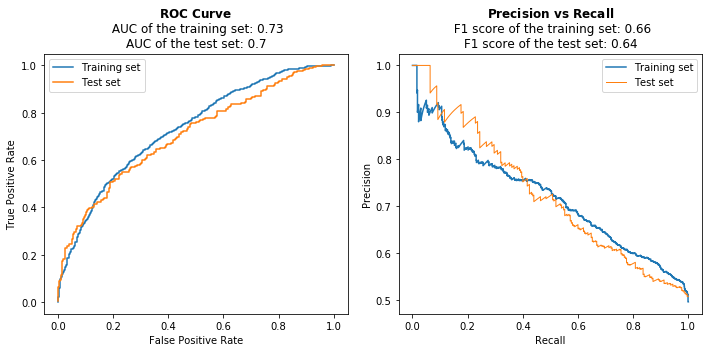

In [389]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].plot(fpr_pca_train,tpr_pca_train,label='Training set')
axes[0].plot(fpr_pca_test,tpr_pca_test,label='Test set')


axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title( r'$\bf{ROC\ Curve}$' + '\n AUC of the training set: {}\nAUC of the test set: {}'.format(round(auc(fpr_pca_train,tpr_pca_train),2),round(auc(fpr_pca_test,tpr_pca_test),2)))
axes[0].legend()

axes[1].plot(recall_pca_train,precision_pca_train,label='Training set')
axes[1].plot(recall_pca_test,precision_pca_test,label='Test set',linewidth=1)

axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')
axes[1].set_title( r'$\bf{Precision\ vs\ Recall}$' + '\n F1 score of the training set: {}\nF1 score of the test set: {}'.format(round(lr_f1_pca_train,2),round(lr_f1_pca_test,2)))
axes[1].legend()

plt.subplots_adjust(wspace=0.5,hspace=.25)
plt.tight_layout()

plt.show()

## Part 3: Linear Discriminant Analysis

### Grid search with cross-validation

In [382]:
pipe_lda = Pipeline([
    ('reduce_dim', LinearDiscriminantAnalysis()),
    ('classify', LogisticRegression())
])

# LDA has a limit of k-1 components given k classes,
# so k cannot be optimized for
param_grid_lda = {
        'classify__C': [0.001, 0.01, 0.1, 1]
    }
grid_lda = GridSearchCV(pipe_lda, cv=3, n_jobs=1, param_grid=param_grid_lda)

grid_lda.fit(X_train, y_train.reshape(len(y_train)))

print('Best C for Logistic Regression: {}'.format(grid_lda.best_estimator_.named_steps['classify'].C))

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Best C for Logistic Regression: 0.01


### LDA + Logistic regression

In [386]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train,y_train)

X_lda_train = lda_clf.transform(X_train)
X_lda_test = lda_clf.transform(X_test)

lr_lda = LogisticRegression(C=grid_lda.best_estimator_.named_steps['classify'].C)

lr_lda.fit(X_lda_train,y_train)



y_lda_probs_train = lr_lda.predict_proba(X_lda_train)[:,1]
fpr_lda_train, tpr_lda_train, thresholds_lda_train = roc_curve(y_train, y_lda_probs_train)
precision_lda_train, recall_lda_train, _lda_tr = precision_recall_curve(y_train, y_lda_probs_train)
lr_f1_lda_train = f1_score(y_train,lr_lda.predict(X_lda_train))

y_lda_probs_test = lr_lda.predict_proba(X_lda_test)[:,1]
fpr_lda_test, tpr_lda_test, thresholds_test = roc_curve(y_test, y_lda_probs_test)
precision_lda_test, recall_lda_test, _lda_test = precision_recall_curve(y_test, y_lda_probs_test)
lr_f1_lda_test = f1_score(y_test,lr_lda.predict(X_lda_test))


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Classifier performance

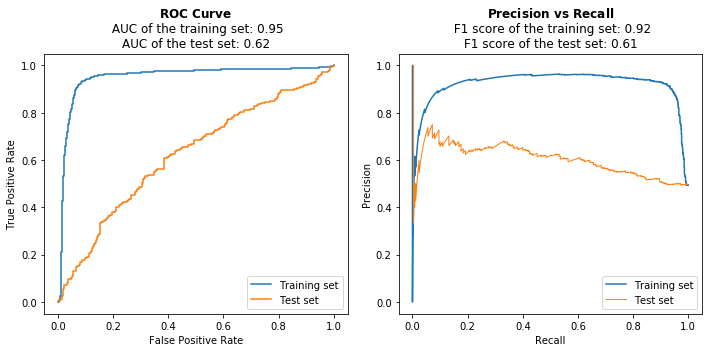

In [388]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].plot(fpr_lda_train,tpr_lda_train,label='Training set')
axes[0].plot(fpr_lda_test,tpr_lda_test,label='Test set')


axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title( r'$\bf{ROC\ Curve}$' + '\n AUC of the training set: {}\nAUC of the test set: {}'.format(round(auc(fpr_lda_train,tpr_lda_train),2),round(auc(fpr_lda_test,tpr_lda_test),2)))
#axes[0].set_title('ROC Curve\nArea under the curve: {}'.format(round(auc(fpr,tpr),2)))
axes[0].legend()

axes[1].plot(recall_lda_train,precision_lda_train,label='Training set')
axes[1].plot(recall_lda_test,precision_lda_test,label='Test set',linewidth=1)

axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')
axes[1].set_title( r'$\bf{Precision\ vs\ Recall}$' + '\n F1 score of the training set: {}\nF1 score of the test set: {}'.format(round(lr_f1_lda_train,2),round(lr_f1_lda_test,2)))
axes[1].legend()

plt.subplots_adjust(wspace=0.5,hspace=.25)
plt.tight_layout()

plt.show()

## Part 4: Visual intuition of classifiers
http://joelgrus.com/2013/06/24/t-shirts-feminism-parenting-and-data-science-part-2-eigenshirts/

### Set up prediction rankings

In [458]:
men_clothes = X[np.where(y.reshape(len(y))==1)]
wo_clothes = X[np.where(y.reshape(len(y))==0)]

#probability of being assigned men for each
#element of each class
pca_men_probs = np.array([lr_pca.predict_proba([x]) for x in pca_clf.transform(men_clothes)]).reshape(len(men_clothes),2)[:,1]
pca_wo_probs = np.array([lr_pca.predict_proba([x]) for x in pca_clf.transform(wo_clothes)]).reshape(len(wo_clothes),2)[:,1]

#manliest men clothes
pca_men_rank = np.argsort(pca_men_probs)[::-1]
#manliest women clothes
pca_wo_rank = np.argsort(pca_wo_probs)[::-1]

#probability of being assigned men for each
#element of each class
lda_men_probs = np.array([lr_lda.predict_proba([x]) for x in lda_clf.transform(men_clothes)]).reshape(len(men_clothes),2)[:,1]
lda_wo_probs = np.array([lr_lda.predict_proba([x]) for x in lda_clf.transform(wo_clothes)]).reshape(len(wo_clothes),2)[:,1]

#manliest men clothes
lda_men_rank = np.argsort(lda_men_probs)[::-1]
#manliest women clothes
lda_wo_rank = np.argsort(lda_wo_probs)[::-1]

### PCA + LR

Most masculine men clothes according to PCA + LR


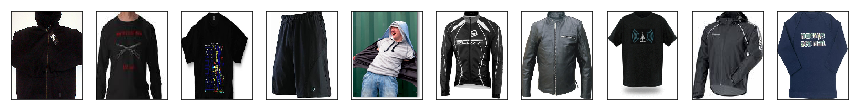

Least masculine men clothes according to PCA + LR


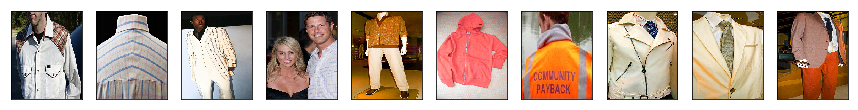

Most femenine women clothes according to PCA + LR


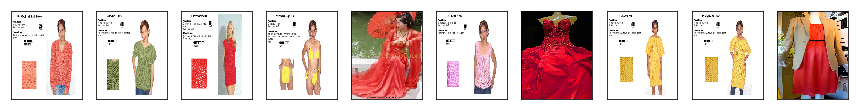

Least femenine women clothes according to PCA + LR


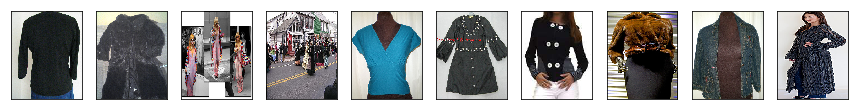

In [491]:

print('Most masculine men clothes according to PCA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(men_clothes[pca_men_rank[i]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

print('Least masculine men clothes according to PCA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(men_clothes[pca_men_rank[i-10]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

print('Most femenine women clothes according to PCA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(wo_clothes[pca_wo_rank[i-10]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

print('Least femenine women clothes according to PCA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(wo_clothes[pca_wo_rank[i]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

### LDA + LR

Manliest men clothes according to LDA + LR


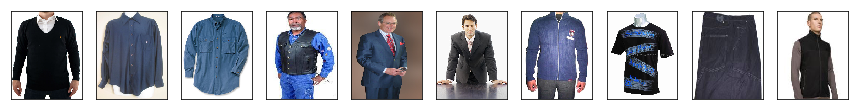

Least manly men clothes according to LDA + LR


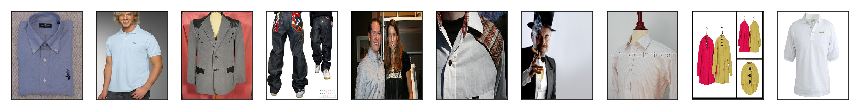

Most femenine women clothes according to LDA + LR


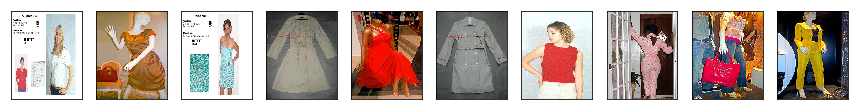

Least femenine women clothes according to LDA + LR


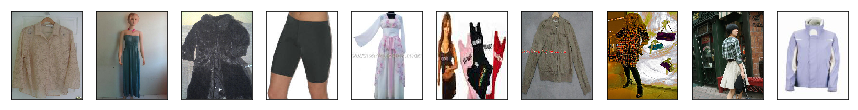

In [490]:

print('Most masculine men clothes according to LDA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(men_clothes[lda_men_rank[i]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

print('Least masculine men clothes according to LDA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(men_clothes[lda_men_rank[i-10]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

print('Most femenine women clothes according to LDA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(wo_clothes[lda_wo_rank[i-10]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

print('Least femenine women clothes according to LDA + LR')
fig, axes = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    axes[i].imshow(flat_to_rgb(wo_clothes[lda_wo_rank[i]],(200,250)))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

plt.show()

## Part 5: Reflection

Principal Component Analysis with 54 components reduces the F1 score  
and AUC of the training set while increasing the same metrics for the test  
set slightly. This tells us that PCA is removing essential information from  
the training data for its correct classification, yet the fact that the  
classification performance of the test set was not affected suggests that  
some of the lost information was specifically relevant for the classification  
of the training data, yet cannot be generalizable to unseen photos.
  
While it looks counterintuitive that LDA can perform similarly with a single  
component than PCA with 54, LDA reduces the data to a 1-dimension linear   
subspace that provides most separability between the classes, and it does so  
in a supervised way: the reduction is informed by the real labels of the data.  
While LDA did cause a decrease in the classification metrics for the training  
set, the metrics did not plummet as compared to the classification of the raw  
training set as with PCA (5% fall in AUC vs 27%). This shows that while PCA  
lost essential information for classification of the training set , LDA focused  
its reduction on keeping the training data as separable as possible.  
  
Both PCA and LDA are dramatically inferior to the state-of-the-art methods  
for image recognition, since, e.g. they cannot infer high-level patterns from  
pixel data. However, for instance, in PCA the images reconstructed from the  
raw components, the "eigenshirts", are supposed to represent the most  
different properties of the images in the data, which should ideally translate  
ultimately into color and shape. By observing the photos classified as most  
manly and most femenine, one can grasp what types of visual aspects these  
pipelines based their decision functions on. Both related very dark colors with  
masculine clothes, PCA+LR focusing on black and LDA+LR on dark blue. They  
both associated yellow, white, pink, and red with femininity. However, there  
seems to be no clear pattern in the shapes of the clothes labeled either way.  
It would be a worthwhile experiment to repeat the training with photos in black  
and white to study the effect of shape independently from color.
  
I do not believe the data available for this experiment allowed to discern  
a better method for dimensionality reduction, since it lacked fundamental  
pre-processing, such as photos having the same background, clothes being  
centered and seen from the sangle angle, etc. Furthermore, while LDA  
preserved the original training classification metrics, the difference in  
performance between PCA+LR and LDA+LR was not significant when testing  
on the test set.